# Initializations

## Imports

In [1]:
# import skimage
import imageio
import numpy as np
from skimage import data, io, color, filters, morphology, util
from skimage.io import imsave, imread
# from skimage import exposure, measure, feature, segmentation, restoration
import matplotlib.pyplot as plt
# from skimage.util import img_as_ubyte
import scipy.ndimage as ndi
import pandas as pd
# import seaborn as sns
import os
from PIL import Image
# import deepcell
# import deepcell.applications.cell_tracking
# from deepcell.applications import Mesmer
import time
import glob
from PIL import Image


## Checking Versions and Conda Env

In [2]:
import matplotlib
print(matplotlib.__version__)
print(matplotlib.__file__)

3.5.1
/ext3/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py


## Path Setting

In [3]:
SCRIPTDIR = os.getcwd()
SCRIPTDIR = '/scratch/ns4964/lionnet/scripts'

os.chdir(SCRIPTDIR)
os.chdir('../inputs/smFISH/')
DATADIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/Mesmer/')
OUTDIR = os.getcwd()

OUTDIR

'/scratch/ns4964/lionnet/output/Mesmer'

## Functions

In [4]:
def TwoChannelSingleZ(file, zstack, channel1, channel2):
    im = file
    skimg = io.imread(im, plugin='tifffile')
    xshape = skimg.shape[2]
    yshape = skimg.shape[3]
    newtif = np.empty((2,xshape,yshape))
    newtif[0,:,:] = skimg[zstack,channel1]
    newtif[1,:,:] = skimg[zstack,channel2]
    return newtif

In [5]:
def showtif(file, zstack=0, channel=0, verbose = False):
    if os.path.isfile(file):
        skimg = io.imread(file, plugin='tifffile')
    else:
        skimg = file
    if len(skimg.shape) == 2:
        img = skimg
    if len(skimg.shape) == 3:
        img = skimg[zstack]
    if len(skimg.shape) == 4:
        img = skimg[zstack,channel]
    if verbose==True:
        print(skimg.shape,"\n", "Showing Z-stack {} of {}".format(zstack+1, skimg.shape[0]))
    plt.axis('off')
    a = plt.imshow(img,cmap='gray')
    return a

# Applying Mesmer
- Following along from example here: <https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Mesmer-Application.ipynb>

## Breakdown of run using single images

(23, 5, 1024, 1024) 
 Showing Z-stack 1 of 23


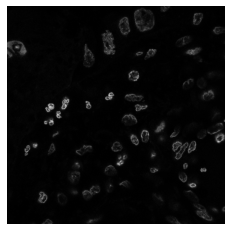

In [15]:
toyfilefull="/scratch/ns4964/lionnet/inputs/smFISH/slide1A_right_BeKi5_HCR_rd2.czi - slide1A_right_BeKi5_HCR_rd2 #09.tif"
showtif(toyfilefull, verbose=True)

(23, 1024, 1024, 2)
Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second.


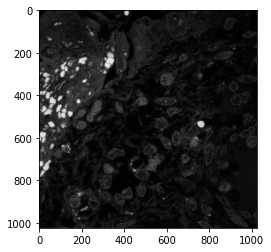

In [16]:
# Input image for Mesmer is full zstack size using channel 0 (nuclear) and 1 (cytoplasmic)
fulltf = io.imread(toyfilefull, plugin='tifffile')
ch1 = fulltf[:,0]
ch2 = fulltf[:,1]
plt.imshow(ch1[5],cmap='gray')
plt.imshow(ch2[5],cmap='gray')

im = np.stack((ch1,ch2),axis=-1)
print(im.shape)
print("Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second.")

In [17]:
from deepcell.utils.plot_utils import create_rgb_image

# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(im, channel_colors=['blue', 'green'])

In [18]:
rgb_images.shape

(23, 1024, 1024, 3)

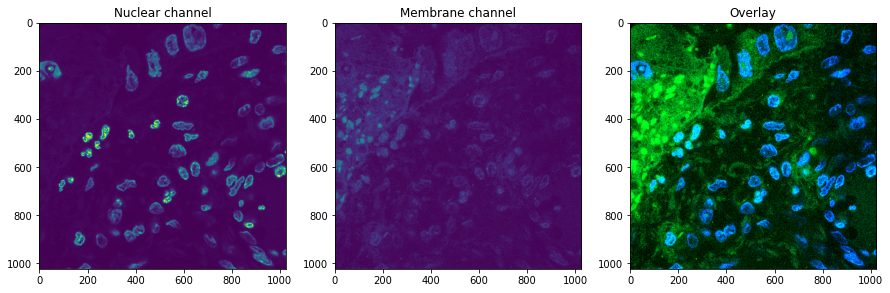

In [19]:
# idx gives z-layer to show for multi layered images
idx = 1
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(im[idx, ..., 0])
ax[1].imshow(im[idx, ..., 1])
ax[2].imshow(rgb_images[idx, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

In [ ]:
from deepcell.applications import Mesmer
app = Mesmer()
labeled_mem = app.predict(im,image_mpp=0.132)
labeled_nuc = app.predict(im,image_mpp=0.132, compartment = 'nuclear')

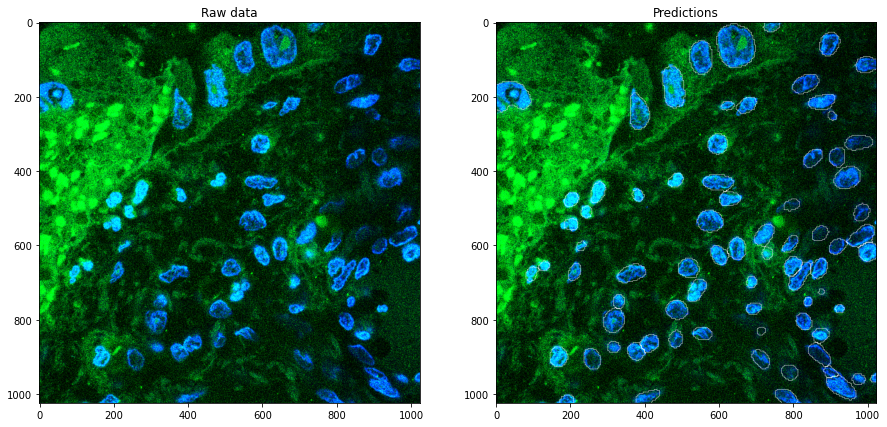

In [21]:
from deepcell.utils.plot_utils import make_outline_overlay
nuc_overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=labeled_nuc)
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(nuc_overlay_data[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()

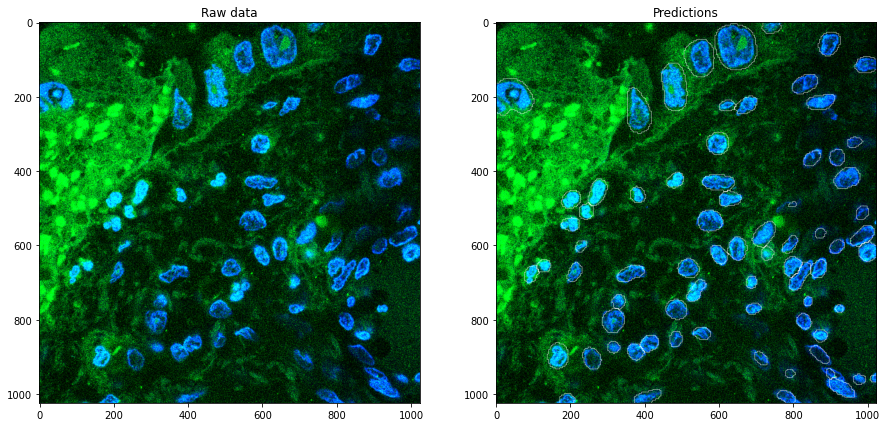

In [22]:
mem_overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=labeled_mem)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(mem_overlay_data[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()

(23, 1024, 1024, 1)


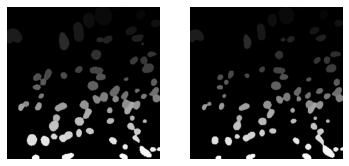

In [23]:
print(labeled_mem.shape)
plt.subplot(1,2,1)
showtif(labeled_mem[:,:,:,0])
plt.subplot(1,2,2)
showtif(labeled_nuc[:,:,:,0])

### Showing only the mask

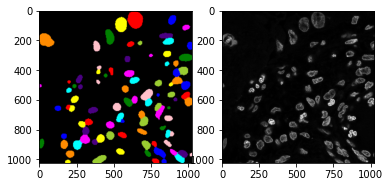

In [24]:
from skimage import measure
teststack = 8
labels = measure.label(labeled_nuc[teststack,:,:,0])
label_overlay = color.label2rgb(labels, bg_label = 0)
labeltest = im[:,:,:,0].copy()
labeltest = labeltest[teststack]
plt.subplot(1, 2, 1)
plt.imshow(label_overlay)
plt.subplot(1, 2, 2)
plt.imshow(labeltest, cmap='gray')

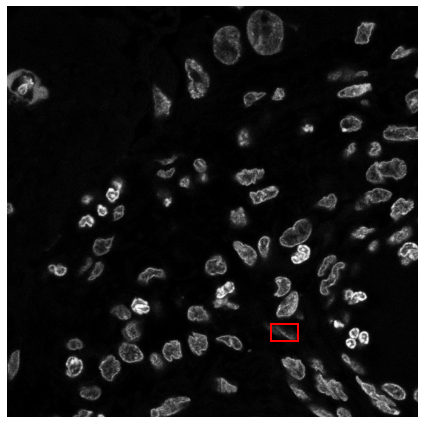

In [25]:
# Adding a boundary box

import skimage.morphology
import matplotlib.patches as mpatches

props = measure.regionprops(labels)

# draw rectangle around segmented coins
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(labeltest, cmap='gray')

minr, minc, maxr, maxc = props[66].bbox
rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

(23, 1024, 1024, 1)


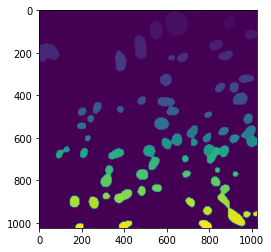

In [26]:
# print(im.shape)
print(labeled_nuc.shape)
plt.imshow(labeled_nuc[0,:,:,0])
labeled_nuc_channel = labeled_nuc[:,:,:,0]
# labeled_nuc_channel.shape

In [27]:
# im[:,:,:,1].shape
labeled_mem.shape

(23, 1024, 1024, 1)

In [28]:
newim = np.stack((labeled_nuc_channel,im[:,:,:,0],im[:,:,:,1]),axis = -1)
newim.shape

(23, 1024, 1024, 3)

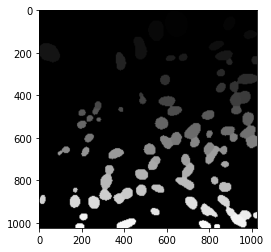

In [29]:
plt.imshow(newim[5,:,:,0],cmap='gray')

## Batch Running

### Make a df for the images

In [30]:
#Move through DATADIR and pull only the files that are folders
os.chdir(DATADIR)

imgfiles=[]
basepath = os.path.realpath('./')
for fname in os.listdir(basepath):
    path = os.path.join(basepath, fname)
    if os.path.isdir(path):
        # skip directories
        continue
    imgfiles.append(path)


In [31]:
# Make imagedf dataframe,
imgdf = pd.DataFrame({'fullpath':imgfiles})
# imgdf.assign(full_path = lambda dataframe: dataframe['OrigName'].map(lambda OrigName: os.path.realpath(OrigName) ))
imgdf = imgdf.assign(imgname = lambda dataframe: dataframe['fullpath'].map(lambda fullpath:(fullpath.split(' - ')[1]).split('.')[0]))
imgdf['zlayers']=''
imgdf['channels']=''
imgdf['x']=''
imgdf['y']=''

for index, row in imgdf.iterrows():
    im = imgdf['fullpath'][index]
    skimg = io.imread(im, plugin='tifffile')
    imgdf.at[index,'zlayers'] = skimg.shape[0]
    imgdf.at[index,'channels'] = skimg.shape[1]
    imgdf.at[index,'x'] = skimg.shape[2]
    imgdf.at[index,'y'] = skimg.shape[3]
imgdf.head()

,fullpath,imgname,zlayers,channels,x,y
0,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #05,23,5,1024,1024
1,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #09,23,5,1024,1024
2,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #11,23,5,1024,1024
3,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #07,23,5,1024,1024
4,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #03,23,5,1024,1024


In [32]:
imgdf.imgname.unique()

array(['slide1A_right_BeKi5_HCR_rd2 #05',
       'slide1A_right_BeKi5_HCR_rd2 #09',
       'slide1A_right_BeKi5_HCR_rd2 #11',
       'slide1A_right_BeKi5_HCR_rd2 #07',
       'slide1A_right_BeKi5_HCR_rd2 #03',
       'slide1A_right_BeKi5_HCR_rd2 #16',
       'slide1A_right_BeKi5_HCR_rd2 #12',
       'slide1A_right_BeKi5_HCR_rd2 #04',
       'slide1A_right_BeKi5_HCR_rd2 #15',
       'slide1A_right_BeKi5_HCR_rd2 #13',
       'slide1A_right_BeKi5_HCR_rd2 #02',
       'slide1A_right_BeKi5_HCR_rd2 #10',
       'slide1A_right_BeKi5_HCR_rd2 #14',
       'slide1A_right_BeKi5_HCR_rd2 #01',
       'slide1A_right_BeKi5_HCR_rd2 #08',
       'slide1A_right_BeKi5_HCR_rd2 #06'], dtype=object)

## v01

### Test Run with single file

In [33]:
# Working function test with dataframe
os.chdir(OUTDIR)

#Specify which channel is to be used for the membrane channel (channel 0 is nuclear)
memchannel = 1

runtest = False
# runtest = True

saveimgs = False
# saveimgs = True

for i in imgdf.index:
    imagefile = imgdf.iloc[i]['fullpath']
    imgname = imgdf.iloc[i]['imgname']

    image = imread(imagefile,plugin='tifffile')
    ch1 = fulltf[:,0]
    ch2 = fulltf[:,1]
    nuc_channel = image[:,0]
    mem_channel = image[:,memchannel]

   # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
    im = np.stack((nuc_channel,mem_channel),axis=-1)

    if runtest:
        app = Mesmer()
        labeled_mem = app.predict(im,image_mpp=0.132)
        labeled_nuc = app.predict(im,image_mpp=0.132, compartment = 'nuclear')

    # if saveimgs:
    #     pilimages = []
    #     # for i in range(1,interptif.shape[0]):
    #     for i in range(interptif.shape[0]):
    #         new = Image.fromarray(interptif[i])
    #         pilimages.append(new)
    #
    #     outname = str(imgname)+'_interp_diff_'+str(stackdiff)+'.tiff'
    #     pilimages[0].save(outname,format='TIFF',save_all=True,append_images=pilimages[1:])


### Define Function

In [34]:
def MesmerizeV01(dataframe,nuclearchannel=0,membranechannel=1,saveimgs=True):
    for i in dataframe.index:
        imagefile = dataframe.iloc[i]['fullpath']
        imgname = dataframe.iloc[i]['imgname']

        image = imread(imagefile,plugin='tifffile')
        ch1 = fulltf[:,0]
        ch2 = fulltf[:,1]
        nuc_channel = image[:,nuclearchannel]
        mem_channel = image[:,membranechannel]

        # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
        im = np.stack((nuc_channel,mem_channel),axis=-1)

        rgb_images = create_rgb_image(im, channel_colors=['blue', 'green'])

        app = Mesmer()
        labeled_mem = app.predict(im,image_mpp=0.132)
        labeled_nuc = app.predict(im,image_mpp=0.132, compartment = 'nuclear')
        # dataframe.at[i,'nucmask']=labeled_nuc
        # dataframe.at[i,'memmask']=labeled_mem

        if saveimgs:
            nuc_overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=labeled_nuc)
            mem_overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=labeled_mem)
            labeled_nuc_channel = labeled_nuc[:,:,:,0]
            labeled_mem_channel = labeled_mem[:,:,:,0]
            nuc_overlay_data = np.stack((labeled_nuc_channel,im[:,:,:,0],im[:,:,:,1]),axis = -1)
            mem_overlay_data = np.stack((labeled_mem_channel,im[:,:,:,0],im[:,:,:,1]),axis = -1)
            nuc_outname = dataframe.iloc[i]['imgname']+'_MesmerNuc.tif'
            mem_outname = dataframe.iloc[i]['imgname']+'_MesmerMem.tif'
            imsave(nuc_outname,nuc_overlay_data)
            imsave(mem_outname,mem_overlay_data)
    return(nuc_overlay_data,mem_overlay_data)

## v02
- Adding the cell tracking to the script

### Running single file

In [35]:
import deepcell.applications.cell_tracking

# Working function test with dataframe
os.chdir(OUTDIR)

#Specify which channel is to be used for the membrane channel (channel 0 is nuclear)
memchannel = 1

runtest = False
runtest = True

saveimgs = False
# saveimgs = True


for i in range(0,2):
    imagefile = imgdf.iloc[i]['fullpath']
    imgname = imgdf.iloc[i]['imgname']

    image = imread(imagefile,plugin='tifffile')
    nuc_channel = image[:,0]
    mem_channel = image[:,memchannel]

    # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
    im = np.stack((nuc_channel,mem_channel),axis=-1)

    ### For Testing ###
    # im = im[0:10]
    # nuc_channel = nuc_channel[0:10]
    ### ###

    if runtest:
        app = Mesmer()
        labeled_mem = app.predict(im,image_mpp=0.132)
        labeled_nuc = app.predict(im,image_mpp=0.132, compartment = 'nuclear')
        nuc = np.expand_dims(nuc_channel,axis=-1)
        labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc,labeled_nuc)
        labeled_nuc_channel = labeldict['y_tracked'][:,:,:,0]
        nuc_final = np.stack((labeled_nuc_channel,im[:,:,:,0],im[:,:,:,1]),axis = -1)


(23, 1024, 1024, 3)
(23, 1024, 1024) 
 Showing Z-stack 1 of 23


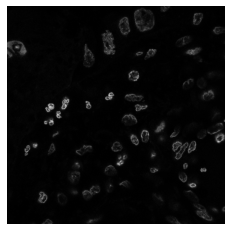

In [36]:
labeled_nuc.shape
print(nuc_final.shape)
# showtif(nuc[:,:,:,0], verbose=True)
# plt.imshow(labeldict['y_tracked'][1],cmap='gray')
showtif(nuc_final[...,1], verbose=True)

In [37]:
# import deepcell.applications.cell_tracking
#
# labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc,labeled_nuc)

### Define Function

In [38]:
def MesmerizeV02(dataframe,nuclearchannel=0,membranechannel=1,image_mpp = 0.132, saveimgs=True):
    for i in dataframe.index:
        imagefile = dataframe.iloc[i]['fullpath']
        imgname = dataframe.iloc[i]['imgname']

        image = imread(imagefile,plugin='tifffile')
        nuc_channel = image[:,nuclearchannel]
        mem_channel = image[:,membranechannel]

        # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
        im = np.stack((nuc_channel,mem_channel),axis=-1)

        app = Mesmer()
        labeled_mem = app.predict(im,image_mpp=image_mpp)
        labeled_nuc = app.predict(im,image_mpp=image_mpp, compartment = 'nuclear')
        nuc = np.expand_dims(nuc_channel,axis=-1)
        labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc,labeled_nuc)

        if saveimgs:
            labeled_nuc_channel = labeldict['y_tracked'][:,:,:,0]
            labeled_mem_channel = labeled_mem[:,:,:,0]
            nuc_final = np.stack((labeled_nuc_channel,im[:,:,:,0],im[:,:,:,1]),axis = -1)
            mem_final = np.stack((labeled_mem_channel,im[:,:,:,0],im[:,:,:,1]),axis = -1)
            nuc_outname = dataframe.iloc[i]['imgname']+'_Mesmer_Nuc.tif'
            mem_outname = dataframe.iloc[i]['imgname']+'_Mesmer_Mem.tif'
            imsave(nuc_outname,nuc_final)
            imsave(mem_outname,mem_final)
    return(nuc_final,mem_final)

In [39]:
testdf = imgdf[0:1].copy()
testdf

,fullpath,imgname,zlayers,channels,x,y
0,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #05,23,5,1024,1024


In [ ]:
testnucimg,testmemimg = MesmerizeV02(testdf,membranechannel=1)

In [41]:
print(testnucimg.shape)
print(testmemimg.shape)

(23, 1024, 1024, 3)
(23, 1024, 1024, 3)


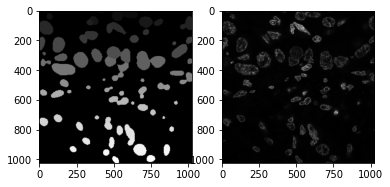

In [42]:
plt.subplot(1, 2, 1)
plt.imshow(testnucimg[0,:,:,0],cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(testnucimg[0,:,:,1],cmap='gray')

In [ ]:
# Running it
os.chdir(OUTDIR)
MesmerizeV02(imgdf,membranechannel=1)

In [44]:
opentif = imread(os.listdir()[1],plugin='tifffile')
opentif.shape

(23, 1024, 1024, 3)

In [45]:
remainderims = imgdf[11:].copy()
remainderims = remainderims.drop(11)
remainderims = remainderims.reset_index(drop=True)
remainderims

,fullpath,imgname,zlayers,channels,x,y
0,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #14,23,5,1024,1024
1,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #01,23,5,1024,1024
2,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #08,23,5,1024,1024
3,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #06,23,5,1024,1024


In [ ]:
MesmerizeV02(remainderims, membranechannel=1)

## v03
- Adding GIF Creation

### Generate a Single Image

In [ ]:
import deepcell.applications.cell_tracking

# Working function test with dataframe
os.chdir(OUTDIR)

#Specify which channel is to be used for the membrane channel (channel 0 is nuclear)
memchannel = 1

runtest = False
runtest = True


for i in range(0, 2):
    imagefile = imgdf.iloc[i]['fullpath']
    imgname = imgdf.iloc[i]['imgname']

    image = imread(imagefile, plugin='tifffile')
    nuc_channel = image[:, 0]
    mem_channel = image[:, memchannel]

    # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
    im = np.stack((nuc_channel, mem_channel), axis=-1)

    ### For Testing ###
    # im = im[0:10]
    # nuc_channel = nuc_channel[0:10]
    ### ###

    if runtest:
        app = Mesmer()
        labeled_mem = app.predict(im, image_mpp=0.132)
        labeled_nuc = app.predict(im, image_mpp=0.132, compartment='nuclear')
        nuc = np.expand_dims(nuc_channel, axis=-1)
        labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc, labeled_nuc)
        labeled_nuc_channel = labeldict['y_tracked'][:, :, :, 0]
        nuc_final = np.stack((labeled_nuc_channel, im[:, :, :, 0], im[:, :, :, 1]), axis=-1)


(23, 1024, 1024, 3)
(23, 1024, 1024) 
 Showing Z-stack 1 of 23


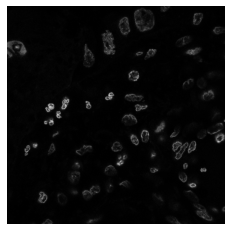

In [48]:
labeled_nuc.shape
print(nuc_final.shape)
# showtif(nuc[:,:,:,0], verbose=True)
# plt.imshow(labeldict['y_tracked'][1],cmap='gray')
showtif(nuc_final[..., 1], verbose=True)

In [49]:
# import deepcell.applications.cell_tracking
#
# labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc,labeled_nuc)

### Make a GIF

In [50]:
# Make a gif
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

makegif = False
makegif = True

trackedgif = HTML(get_js_video(np.expand_dims(labeldict['y_tracked'], axis=0), batch=0, cmap='cubehelix', vmin=0,
                               vmax=len(labeldict['tracks'])))
inputgif = HTML(get_js_video(np.expand_dims(nuc, axis=0), batch=0, cmap='gray'))

In [51]:
trackedgif

#### For Writing/Saving Gifs (From example)
- Does not make colored gif

In [52]:
# Working
raw = []
tracked = []

savegif = False

for i in range(labeldict["X"].shape[0]):
    new_image = labeldict["X"][i, ..., 0]
    # raw_path = os.path.join(OUTDIR, 'image_%d.tiff' % i)
    raw.append(new_image.astype('uint8'))

    label_image = labeldict["y_tracked"][i, ..., 0].astype('uint8')
    label_path = os.path.join(OUTDIR, 'label_%d.tiff' % i)
    tracked.append(label_image.astype('uint8'))

# Make gifs
if savegif:
    imageio.mimsave(os.path.join(OUTDIR, 'raw.gif'), raw)
    imageio.mimsave(os.path.join(OUTDIR, 'tracked.gif'), tracked)

#### Testing Other Methods

In [53]:
import random

plot_masks = labeldict['y_tracked'].copy()
plot_masks = np.rollaxis(np.squeeze(plot_masks), 0, 3)
colors = np.empty(plot_masks.shape, dtype='<U9')
color_dict = dict()

In [54]:
for label in np.unique(plot_masks):
    if label != 0:
        color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None
    color_dict[label] = color
    colors = np.where(plot_masks == label, color, colors)

In [55]:
# Scratch
colors.shape
plot_masks.shape
nuc.shape
# plt.imshow(plot_masks[...,1],cmap='gnuplot2')


(23, 1024, 1024, 1)

In [58]:
from PIL import Image
# imgs = (Image.open(f) for f in nuc)
# img = next(imgs)
# img.save(fp="testraw.gif", format='GIF', append_images=imgs, save_all=True, duration=300, loop=0)

#### Method to use

In [60]:
# Second Method

cmap = 'gnuplot2'
cmap = 'cubehelix'

filenames = []

for i in range(labeldict["X"].shape[0]):
    # Create Images
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(121)
    ax.axis('off')
    plt.imshow(labeldict["X"][i, ..., 0], cmap='gray')
    ax = fig.add_subplot(122)
    ax.axis('off')
    plt.imshow(labeldict["y_tracked"][i, ..., 0], cmap=cmap)
    plt.tight_layout()

    filename = os.path.join(OUTDIR, f'compare_{i / 100:.2f}.tiff')
    filenames.append(filename)
    plt.savefig(filename, dpi=96)
    plt.close()

# Create a gif from the generated images
fp_in = "compare_*.tiff"
fp_out = "compare.gif"
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

# Remove all of the images
for filename in set(filenames):
    os.remove(filename)

print("Done")

Done


### Define Function

In [62]:
def MesmerizeV03(dataframe,nuclearchannel=0,membranechannel=1,image_mpp = 0.132, saveimgs=True, savegifs=False):
    for i in dataframe.index:
        imagefile = dataframe.iloc[i]['fullpath']
        imgname = dataframe.iloc[i]['imgname']

        image = imread(imagefile,plugin='tifffile')
        nuc_channel = image[:,nuclearchannel]
        mem_channel = image[:,membranechannel]

        # Required to have 4 dimensions: [batch, x, y, channel], with nuclear channel first and cytoplasmic channel second."
        im = np.stack((nuc_channel,mem_channel),axis=-1)

        app = Mesmer()
        labeled_mem = app.predict(im,image_mpp=image_mpp)
        labeled_nuc = app.predict(im,image_mpp=image_mpp, compartment = 'nuclear')
        nuc = np.expand_dims(nuc_channel,axis=-1)
        labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc,labeled_nuc)

        if saveimgs:
            labeled_nuc_channel = labeldict['y_tracked'][:,:,:,0]
            labeled_mem_channel = labeled_mem[:,:,:,0]
            nuc_final = np.stack((labeled_nuc_channel,im[:,:,:,0],im[:,:,:,1]),axis = -1)
            mem_final = np.stack((labeled_mem_channel,im[:,:,:,0],im[:,:,:,1]),axis = -1)
            nuc_outname = dataframe.iloc[i]['imgname']+'_Mesmer_Nuc.tif'
            mem_outname = dataframe.iloc[i]['imgname']+'_Mesmer_Mem.tif'
            imsave(nuc_outname,nuc_final)
            imsave(mem_outname,mem_final)

        if savegifs:
            cmap = 'cubehelix'
            filenames = []
            for i in range(labeldict["X"].shape[0]):
                # Create Images
                fig = plt.figure(figsize=(16, 8))
                ax = fig.add_subplot(121)
                ax.axis('off')
                plt.imshow(labeldict["X"][i, ..., 0], cmap='gray')
                ax = fig.add_subplot(122)
                ax.axis('off')
                plt.imshow(labeldict["y_tracked"][i, ..., 0], cmap=cmap)
                plt.tight_layout()

                filename = os.path.join(OUTDIR, f'compare_{i / 100:.2f}.tiff')
                filenames.append(filename)
                plt.savefig(filename, dpi=96)
                plt.close()
            # Create a gif from the generated images
            fp_in = "compare_*.tiff"
            fp_out = f'{imgname}_tracked_comparison.gif'
            imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
            img = next(imgs)  # extract first image from iterator
            img.save(fp=fp_out, format='GIF', append_images=imgs,
                     save_all=True, duration=200, loop=0)
            # Remove all of the images
            for filename in set(filenames):
                os.remove(filename)
    return(nuc_final,mem_final)

### Run single image with function

In [63]:
testdf = imgdf[0:1].copy()
testdf

,fullpath,imgname,zlayers,channels,x,y
0,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #05,23,5,1024,1024


In [64]:
start_time = time.time()
testnucimg,testmemimg = MesmerizeV03(testdf,membranechannel=1,savegifs=True)
print("--- %s seconds ---" % round((time.time() - start_time),0))

/state/partition1/job-18885426/ipykernel_1242081/674894063.py:26: UserWarning: slide1A_right_BeKi5_HCR_rd2 #05_Mesmer_Nuc.tif is a low contrast image
  imsave(nuc_outname,nuc_final)
/state/partition1/job-18885426/ipykernel_1242081/674894063.py:27: UserWarning: slide1A_right_BeKi5_HCR_rd2 #05_Mesmer_Mem.tif is a low contrast image
  imsave(mem_outname,mem_final)


--- 110.0 seconds ---


In [65]:
print(testnucimg.shape)
print(testmemimg.shape)

(23, 1024, 1024, 3)
(23, 1024, 1024, 3)


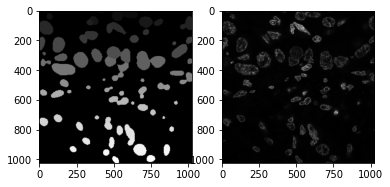

In [66]:
plt.subplot(1, 2, 1)
plt.imshow(testnucimg[0,:,:,0],cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(testnucimg[0,:,:,1],cmap='gray')

# Run Latest Version

In [ ]:
os.chdir(OUTDIR)
start_time = time.time()
MesmerizeV03(imgdf,membranechannel=1, savegifs=True)

In [68]:
print("--- %s minutes ---" % round(((time.time() - start_time)/60),1))

--- 29.5 minutes ---


# TODO
    - Batch run and save all of the outputs
    - Try different combinations of the channels for the membrane channel.
